Code to generate expected S11 for antennas at different heights. This is the first part of EIGSEP memo #10, see https://eigsep.github.io/notebooks/EIGSEP_terrain_reflection.html.

The code as used in the memo implictly assumes a relative permittivity of 1 (appropriate for vacuum, not for the canyon) and implements slightly confusing terminolgy. Here, we reproduce the results from the memo and compare with realistic values for the permittivity.

We consider reflections of waves off the canyon walls.

The reflection coefficient assuming normal incidence is
$$R = \frac{\tilde{n}_0-\tilde{n}}{\tilde{n}_0+\tilde{n}}, $$
where the complex index of refraction of the canyon is denoted $\tilde{n}$ and the index of refraction of air is $\tilde{n}_0$ (assumed to be 1 here).
The refractive index is related to the complex relative permittivity $\tilde{\epsilon}_r$, which depends on the real-valued relative permittivity $\epsilon_r$ and conductivity $\sigma$ through the following relations:
$$\tilde{n} = \sqrt{\tilde{\epsilon}_r},$$
$$\tilde{\epsilon}_r = \epsilon_r - i \frac{\sigma}{\omega \epsilon_0},$$
with $\omega$ the angular frequency.

Note that the equations here are in SI units and assume a non-magnetic medium. The relative permittivity and conductivity are locally independent quantities. They are related through the Kramers-Kronig relation, but this requires knowing (or assuming a model for) the conductivity as a function of frequency.

The conductivity is related to the resisitivty $\rho$ simply through $\sigma = 1/\rho$.

In cgs units, we get for the permittivity

$$\tilde{\epsilon}_r = \epsilon_r - i \frac{4\pi\sigma}{\omega}.$$
Everything else is the same.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import epsilon_0, c
from scipy.interpolate import interp1d
import healpy as hp
import hera_filters
import eigsep_terrain.utils as etu

%matplotlib widget

/home/christian/Documents/research/eigsep/eigsep_terrain/.venv/lib/python3.12/site-packages/eigsep_terrain/__init__.py:11: UserWarning: img module could not be imported, install extra dependencies from pyproject.toml to enable it.
  warn(


In [2]:
# from the memo
RESISTIVITY_OHM_M = 3e2 # Ohm m, middle of the road?

def conductivity_from_resistivity(resistivity_ohm_m):
    '''Return the conductivity of a material given resistivity [Ohm m].'''
    return 1 / (resistivity_ohm_m * 1.113e-12 * 100)

def permittivity_from_conductivity(conductivity, freqs):
    '''Return the electromagnetic permittivity given a conductivity and a frequency [Hz].'''
    omega = 2 * np.pi * freqs  # Hz
    eta = np.sqrt(1 + 1j * 4 * np.pi * conductivity / omega)
    return eta

# note that the memo used the power reflection coefficient |R|^2
def reflection_coefficient(eta, eta0=1):
    '''Return the reflection coefficient crossing from eta0 to eta [permittivity].'''
    return np.abs((eta0 - eta) / (eta0 + eta))**2

def reflectivity(freqs, resistivity_ohm_m=RESISTIVITY_OHM_M, eta0=1):
    conductivity = conductivity_from_resistivity(resistivity_ohm_m)
    eta = permittivity_from_conductivity(conductivity, freqs)
    R = reflection_coefficient(eta, eta0=eta0)
    return R

The memo implements the equations in cgs, although resistivity is given in SI. The conversion to cgs is done in conductivity_from_resisitivty.


In [3]:
si_to_cgs = 4*np.pi*epsilon_0
print(si_to_cgs)  # 1.113e-10 as used above

1.1126500562018527e-10


It is clear from the equations that permittiivty_from_conductivity actually returns the refractive index in the case where $\epsilon_r=1$. The sign difference for the imaginary part does not matter in this case, as long as it is consistent.

In [4]:
def load_S11(freqs, filename="S11_eigsep_bowtie_oct25.npz"):
    """
    Load S11 file. My (CHB) file might differ from the one used in the memo. It has frequency in MHz and S11 in dB.
    This function assumes those units.

    """
    npz = np.load(filename)
    mdl_freqs = npz["freqs"] * 1e6  # MHz to Hz
    mdl_S11_dB = npz["S11"]
    mdl_S11 = 10**(mdl_S11_dB/20)
    mdl_interp = interp1d(mdl_freqs, mdl_S11, kind="cubic", fill_value=0, bounds_error=False)
    S11 = mdl_interp(freqs)
    return S11

[  1.          13.55555556  26.11111111  38.66666667  51.22222222
  63.77777778  76.33333333  88.88888889 101.44444444 114.        ]


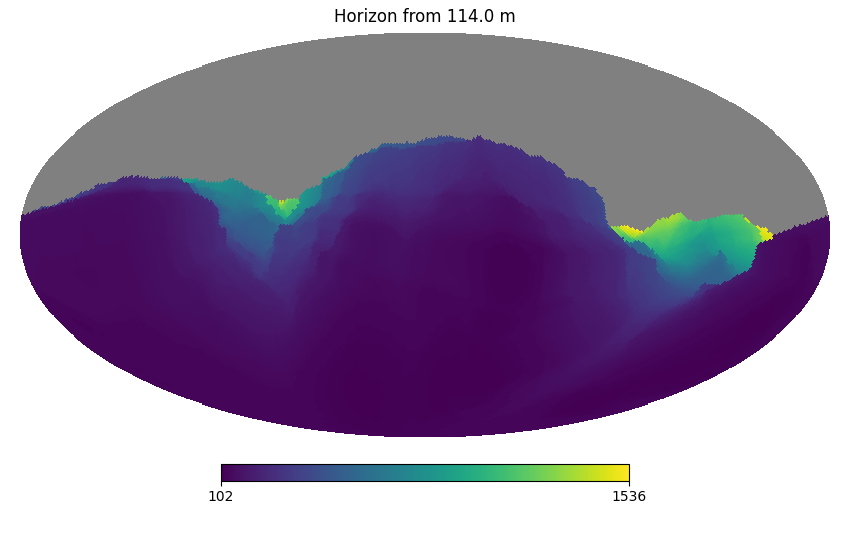

In [5]:
# memo results

NCHAN = 512
freqs = np.linspace(50e6, 250e6, NCHAN)
S11 = load_S11(freqs, filename="S11_eigsep_bowtie_oct25.npz")
df = freqs[1] - freqs[0]
tau_bins = np.linspace(0, 1/(2*df), NCHAN//2+1, endpoint=False)
bin_edges = np.empty(NCHAN//2+2, dtype=tau_bins.dtype)
dbin = tau_bins[1] - tau_bins[0]
bin_edges[:-1] = tau_bins - dbin/2
bin_edges[-1] = tau_bins[-1] + dbin/2
window = hera_filters.dspec.gen_window('bh7', freqs.size)
gamma = reflectivity(freqs)


HORIZON_NPZ = "horizon_models_v000.npz"
npz = np.load(HORIZON_NPZ)
heights = npz["heights"]
print(heights)
hp.mollview(npz["r"][-1], title=f"Horizon from {heights[-1]} m")
plt.show()

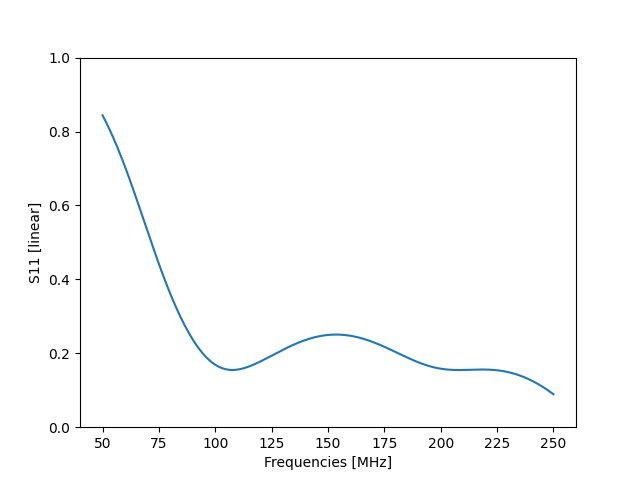

In [6]:
plt.figure()
plt.plot(freqs/1e6, S11)
plt.ylabel("S11 [linear]")
plt.xlabel("Frequencies [MHz]")
plt.ylim(0, 1)
plt.show()

Expected height = 1, Actual height = 1.0
Expected height = 5, Actual height = 1.0
Expected height = 10, Actual height = 13.555555555555555
Expected height = 25, Actual height = 26.11111111111111
Expected height = 50, Actual height = 51.22222222222222
Expected height = 75, Actual height = 76.33333333333333
Expected height = 100, Actual height = 101.44444444444444


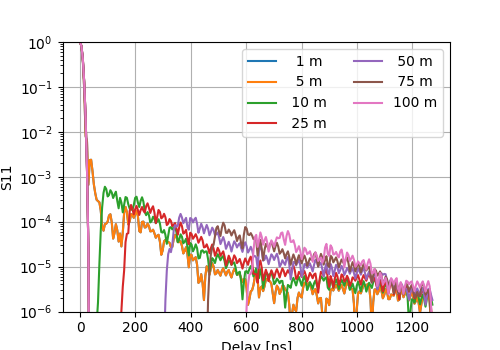

In [7]:
plt.figure(figsize=(5, 3.5))
for height in [1, 5, 10, 25, 50, 75, 100]:
    ix = np.argmin(np.abs(heights-height))
    print(f"Expected height = {height}, Actual height = {heights[ix]}") 
    rmag = npz["r"][ix]
    is_gnd = ~np.isnan(rmag)
    weights = 1 / rmag[is_gnd]  # incoherent scattering, for voltage
    hist, _ = np.histogram(2 * rmag[is_gnd] / c, weights=weights, bins=bin_edges)
    spec = 1 + np.fft.irfft(hist) * gamma * (1 - S11)**2  # square 1-S11 to account for out and back
    dspec = np.fft.rfft(spec * window)
    dspec /= dspec[0]
    plt.semilogy(tau_bins * 1e9, np.abs(dspec), label=f'{height:3.0f} m')
plt.ylim(1e-6, 1e0)
plt.ylabel('S11')
plt.grid()
plt.legend(ncol=2, loc='best')
plt.xlabel('Delay [ns]')
#plt.tight_layout()
plt.show()

Note that the heights in the legend are not the actual heights. Under the hood, the code uses the nearest-neighbor height. This is why the 1m and 5m lines are identical.

Now, we use a more realistic realtive permittivity. The canyon consist mainly of shale and limestone. For limestone, $\epsilon_r=7-9.2$ according to Parasnis 1956. It increases wiuth water content. For dry shale (at 100 MHz), Josh et al. 2016 gives $\epsilon_r=5$. This increases to 8 for water-saturated shale.

True
True


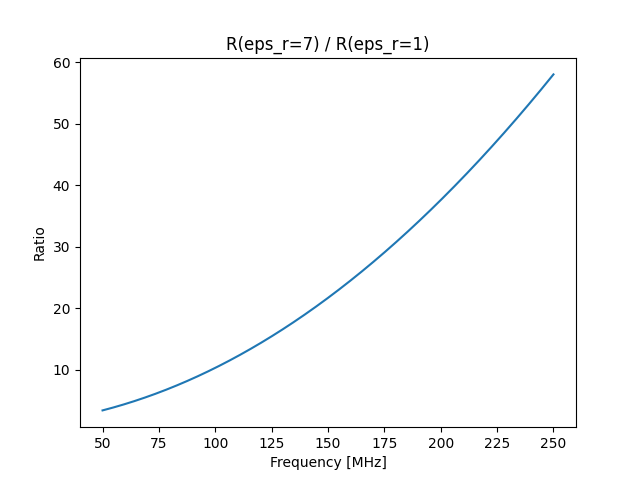

In [8]:
EPS_R = 7  # some mix of limestone and shale
sigma = etu.conductivity_from_resistivity(RESISTIVITY_OHM_M)

# ensure we get the same value as before for eps_r=1
n_memo = etu.complex_ref_index(1, sigma, freqs)
r_memo = reflection_coefficient(n_memo)
print(np.allclose(gamma, r_memo))

# the old conductivity_to_permittivity still works for eps_r=1
n_memo2 = etu.permittivity_from_conductivity(sigma, freqs)
print(np.allclose(n_memo, n_memo2))

# realistic reflection coefficient
n_tilde = etu.complex_ref_index(EPS_R, sigma, freqs)
r_realistic_power = reflection_coefficient(n_tilde)


plt.figure()
plt.plot(freqs/1e6, r_realistic_power/r_memo)
plt.title(f"R(eps_r={EPS_R}) / R(eps_r=1)")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Ratio")
plt.show()

Expected height = 1, Actual height = 1.0
Expected height = 5, Actual height = 1.0
Expected height = 10, Actual height = 13.555555555555555
Expected height = 25, Actual height = 26.11111111111111
Expected height = 50, Actual height = 51.22222222222222
Expected height = 75, Actual height = 76.33333333333333
Expected height = 100, Actual height = 101.44444444444444


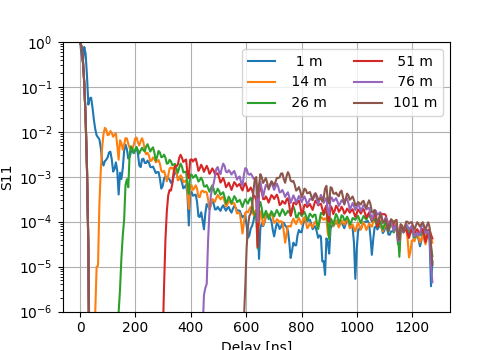

In [9]:
dspec = {}

for height in [1, 5, 10, 25, 50, 75, 100]:
    ix = np.argmin(np.abs(heights-height))
    print(f"Expected height = {height}, Actual height = {heights[ix]}") 
    rmag = npz["r"][ix]
    is_gnd = ~np.isnan(rmag)
    weights = 1 / rmag[is_gnd]  # incoherent scattering, for voltage
    hist, _ = np.histogram(2 * rmag[is_gnd] / c, weights=weights, bins=bin_edges)
    spec = 1 + np.fft.irfft(hist) * r_realistic_power * (1 - S11)**2  # square 1-S11 to account for out and back
    _dspec = np.fft.rfft(spec * window)
    _dspec /= _dspec[0]
    dspec[str(heights[ix])] = _dspec

plt.figure(figsize=(5, 3.5))
for h, d in dspec.items():
    plt.semilogy(tau_bins * 1e9, np.abs(d), label=f'{float(h):3.0f} m')
plt.ylim(1e-6, 1e0)
plt.ylabel('S11')
plt.grid()
plt.legend(ncol=2, loc='best')
plt.xlabel('Delay [ns]')
#plt.tight_layout()
plt.show()

## Mathematical Review

There appears to be some mix of voltages and powers above. Here we try to do a careful accounting of units and dimensions.

The most complete treatment is using complex voltages and electric fields, carrying all phase information. That involves complex S11, antenna beam, and refractive index and account for polarization, angle of incidence, coherence etc. This is too detailed for us since we just want a qualitative picture. Also, since the canyon surface varies at sub-wavelength scales and we use a simple model of the canyon reflective properties, the phases can be taken to be effectively random. In the limit of rmany andom phases that cancel, we might as well work with powers (incoherent addition).

The radar equation is:

$$P_{r} = \frac{P_t G^2 \lambda^2 \sigma}{(4\pi)^3 r^4}.$$

Here, $G$ is the antenna gain (including S11 and beam) and we need two factors for transmitting and receiving; $\sigma$ is the cross-section of the scatterer which usually depends on $\lambda$, the area of the scatterer, and it's complex permittivity; and $r$ is the distance to the scatterer. The power received at the scattering surface decays as $r^2$, then there's a second factor of $r^2$ on the way back to the transmitter. The spherical wave expands twice. Note that the analysis above only had one factor of $r$ for a field level treatment, but we see here that it should have had two factors of $r$.

We simplify and assume an isotropic beam, so $G \propto (1 - |S_{11}|^2)$. For the cross-section, we use a simple model for a flat plate of area A:

$$\sigma = \frac{4\pi A^2}{\lambda^2} |R|^2,$$

where R is the complex reflection coefficient given above.

The received power becomes (up to a direction-independent constant of proportionality $C^2$):

$$P_{r} = C^2 \frac{(1 - |S_{11}|^2)^2 A^2}{(4\pi)^2 r^4} P_{t}, \\
\frac{P_r}{P_t} = \left(\frac{C}{4\pi}\right)^2 \frac{(1 - |S_{11}|^2)^2 A^2 |R|^2}{r^4}.$$

This is for each reflector. In our analysis, we divide the terrain into HealPixels where we know the distance to each pixel. The solid angle $\Omega$ of each pixel is constant, but the area $A$ scales with the square of the distance. There's also a dependence on the angle between the surface normal and the line-of-sight, but we ignore that here. We therefore get $A = r^2 \Omega = 4\pi r^2/\mathrm{Npix}$. It would be unphysical to cancel $A^2/r^4$ since we would give too much weight to far-away pixels. Instead we note that our flat-plate model for $\sigma$ only applies for small coherent patches of area $A_{\rm coh} \sim \lambda^2$. Assume that a pixel of area $A$ can be divided into $N$ coherent patches. Then $A = N A_{\rm coh}$ and the power received from that pixel is given as

$$P_{r} = \sum_{j=1}^{N} P_{r, j} \propto \sum_{j=1}^{N} A_{\rm coh}^2 \propto N A_{\rm coh}^2 = A A_{\rm coh} = A \lambda^2.$$

We see that the right formula uses the product $A A_{\rm coh}$, not straight up $A^2$.
The power from each pixel becomes
$$\frac{P_r}{P_t} = \left(\frac{C}{4\pi}\right)^2 \frac{(1 - |S_{11}|^2) ^2A \lambda^2 |R|^2}{r^4} = \tilde{C}^2 \frac{(1 - |S_{11}|^2)^2 \lambda^2 |R|^2}{r^2},$$

and the updated S11 is the ratio of the voltages
$$\frac{V_r}{V_t} = \tilde{C} \frac{(1 - |S_{11}|^2) \lambda |R|}{r} e^{-i2\pi\nu (2r/c)},$$
which picks up a phase corresponding to the delay of the reflected wave. It is crucial to carry this phase, and unlike the other phases, it is not random and does not cancel.

We leave out the free-space component for our delay-plot since we mostly care about the environmental coupling. The unknown scale $\tilde{C}$ is removed by normalizing by the integrated S11 over frequency.

In [10]:
# realistic and complex reflection coefficient
R = etu.reflection_coefficient(n_tilde)

def s11_terrain(freqs, s11, height, R=R):
    """
    Compute S11 from terrain scattering.

    Parameters
    ----------
    freqs : ndarray
        Frequencies of measurement in Hz
    s11 : ndarray
        Magnitude of S11 for antenna in free space (only reflection at the receiver input)
    height : float
        Antenna height above the canyon ground (nearest-neighbor interpolated to grid of heights we have)
    R : ndarray
        Complex reflection coeffiecient of ground as a function of frequency
    C : float
        Relative strength of reflected contribution

    Returns
    -------
    s11_t : ndarray
       S11 due to environment effects, as a function of frequency
    h : float
        The height used for the calculation (nearest the input height)

    """
    ix = np.argmin(np.abs(heights-height))
    h = heights[ix]
    rmag = npz["r"][ix]
    is_gnd = ~np.isnan(rmag)

    dlys = 2 * rmag[is_gnd] / c
    phases = np.exp(-1j * 2*np.pi * dlys[None, :] * freqs[:, None])
    transmission = 1 - s11**2
    lam = c/freqs

    # terrain component vs freq
    s11_t = np.sum((1/rmag[is_gnd])[None, :] * (transmission * np.abs(R) * lam)[:, None] * phases, axis=1)
    
    return s11_t, h

s11_t = {}
for height in [1, 5, 10, 25, 50, 75, 100]:
    s, h = s11_terrain(freqs, S11, height)
    s11_t[str(h)] = s

s11_delay = {k: np.fft.ifft(v * window) for k, v in s11_t.items()}
dly = np.fft.fftfreq(freqs.size, d=freqs[1]-freqs[0])

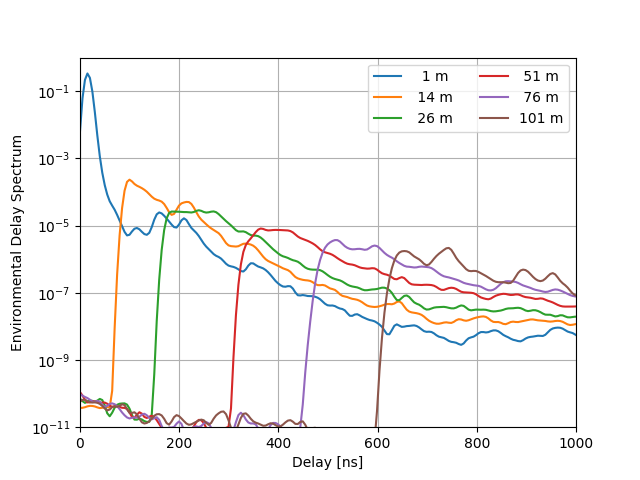

In [11]:
delay_spec = {}
norm = np.sum(np.abs(s11_delay["1.0"])**2)
plt.figure()
for h, d in s11_delay.items():
    label = f"{float(h):3.0f} m"
    power = np.abs(d)**2
    delay_spec[h] = power/norm
    plt.semilogy(np.fft.fftshift(dly) * 1e9, np.fft.fftshift(power/norm), label=label)
plt.xlim(0, 1000)
plt.ylim(1e-11, 1e0)
plt.grid()
plt.legend(ncol=2, loc="best")
plt.xlabel("Delay [ns]")
plt.ylabel("Environmental Delay Spectrum")
plt.show()

In [12]:
np.savez("/home/christian/Documents/research/papers/eigsep_instrument/notebooks/s11_terrain.npz", **delay_spec, dly=dly*1e9)